<a href="https://colab.research.google.com/github/Inno732/Defi_IA_1_2023_2024/blob/main/Final_XAI_Gradcam_classification_tf_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**1. Intaller le module d'explicabilité "tf-explain"**

In [ ]:
!pip install tf-explain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 777.4 kB/s eta 0:00:00


#**2. Importer les libraries**

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import tf_explain
from tf_explain.core.grad_cam import GradCAM
from tf_explain.core.smoothgrad import SmoothGrad
from keras.models import load_model
import cv2

#**3. Télécharger la base d'images de test**

In [ ]:
!rm -rf sample_data
!wget https://nextcloud.ig.umons.ac.be/s/RsZpqtYfDgYzKxr/download/test.zip
!unzip test.zip
! rm test.zip

--2023-11-28 21:34:20--  https://nextcloud.ig.umons.ac.be/s/RsZpqtYfDgYzKxr/download/test.zip
Resolving nextcloud.ig.umons.ac.be (nextcloud.ig.umons.ac.be)... 193.190.209.220
Connecting to nextcloud.ig.umons.ac.be (nextcloud.ig.umons.ac.be)|193.190.209.220|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57038454 (54M) [application/zip]
Saving to: ‘test.zip’

test.zip            100%[===================>]  54.40M  2.51MB/s    in 24s     

2023-11-28 21:34:46 (2.23 MB/s) - ‘test.zip’ saved [57038454/57038454]

Archive:  test.zip
   creating: test/
   creating: test/fire/
  inflating: test/fire/F_1001.jpg    
  inflating: test/fire/F_2062.jpg    
  inflating: test/fire/F_2063.jpg    
  inflating: test/fire/F_2064.jpg    
  inflating: test/fire/F_2066.jpg    
  inflating: test/fire/F_2067.jpg    
  inflating: test/fire/F_2068.jpg    
  inflating: test/fire/F_2070.jpg    
  inflating: test/fire/F_2071.jpg    
  inflating: test/fire/F_2072.jpg    
  inflating: test/

In [ ]:
!printf '%s\n' 'fire' 'no_fire' 'start_fire'> classes.txt

In [ ]:
dataset_name='test'
#test_dataset = os.path.join('bases/', dataset_name)
classes_path = "classes.txt"

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
	dataset_name,
	batch_size= 8,      # Taille du mini-batch
  label_mode= 'categorical'    # Conversion au format One-Hot
)                             # Generates a 'tf.data.Dataset' from image files in a directory (train_dataset)
print(test_ds.class_names)

Found 300 files belonging to 3 classes.
['fire', 'no_fire', 'start_fire']


#**4. Télécharger votre modèle**

In [ ]:
!wget https://nextcloud.ig.umons.ac.be/s/p2xNRJZqZ5zCrW6/download/small_MobileNetV2_2023_test.h5

In [ ]:
!wget https://nextcloud.ig.umons.ac.be/s/p2xNRJZqZ5zCrW6/download/model_VGG16_8r5eqnu.h5

--2023-11-28 21:27:12--  https://nextcloud.ig.umons.ac.be/s/p2xNRJZqZ5zCrW6/download/model_VGG16_8r5eqnu.h5
Resolving nextcloud.ig.umons.ac.be (nextcloud.ig.umons.ac.be)... 193.190.209.220
Connecting to nextcloud.ig.umons.ac.be (nextcloud.ig.umons.ac.be)|193.190.209.220|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20054808 (19M) [application/octet-stream]
Saving to: ‘model_VGG16_8r5eqnu.h5’

model_VGG16_8r5eqnu 100%[===================>]  19.12M  2.76MB/s    in 6.9s    

2023-11-28 21:27:21 (2.76 MB/s) - ‘model_VGG16_8r5eqnu.h5’ saved [20054808/20054808]



In [ ]:
!wget https://nextcloud.ig.umons.ac.be/s/p2xNRJZqZ5zCrW6/download/model_VGG19_epD3OKv.h5
!wget https://nextcloud.ig.umons.ac.be/s/p2xNRJZqZ5zCrW6/download/model_rsnt50.h5
!wget https://nextcloud.ig.umons.ac.be/s/p2xNRJZqZ5zCrW6/download/model_xception_1.h5
!wget https://nextcloud.ig.umons.ac.be/s/p2xNRJZqZ5zCrW6/download/model_DsNt121_1.h5

In [ ]:
# Load pretrained model or your own
model = load_model("small_MobileNetV2_2023_test.h5")

In [ ]:
model_VGG16 = load_model("model_VGG16_8r5eqnu.h5")

In [ ]:
# Replace 'model_file.h5' with your uploaded model file name
model_path = 'model_VGG16 (2).h5'

# Load the pre-trained model into a variable
model_VGG16 = load_model(model_path)

In [ ]:
model_VGG16.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 299, 299, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 299, 299, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 149, 149, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 149, 149, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 149, 149, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 74, 74, 128)       0     

In [ ]:
model_VGG19 = load_model("model_VGG19_epD3OKv.h5")

In [ ]:
model_DsNt121 = load_model("model_DsNt121_1.h5")

In [ ]:
model_rsnt50 = load_model("model_rsnt50.h5")

In [ ]:
model_xception = load_model("model_xception_1.h5")

In [ ]:
input_dim =299

#**5. Définir la classe à expliquer**

In [ ]:
className="Fire"
#className="start_fire"
!mkdir -p className/className

In [ ]:
classes = test_ds.class_names

#**6. Sélectionner 3 images de test**

In [ ]:
images_to_test = ["test/fire/test005.jpg",
                  "test/fire/test013.jpg",
                  "test/fire/test007.jpg",
                  "test/fire/F_2062.jpg",
                  "test/fire/F_2063.jpg",
                  "test/fire/F_2064.jpg",
                  "test/fire/F_2066.jpg",
                  "test/fire/F_2067.jpg",
                  "test/fire/F_2080.jpg",
                  "test/fire/F_2062.jpg",
                  "test/start_fire/test101.jpg",
                  "test/start_fire/test122.jpg",
                  "test/start_fire/NorthAmerica (79).png",
                  "test/start_fire/test106.jpg",
                  "test/start_fire/test118.jpg",
                  "test/fire/test019.jpg",
                  "test/fire/test002.jpg",
]

#**4. Expliquer le modèle avec la méthode XAI "GradCAM"**

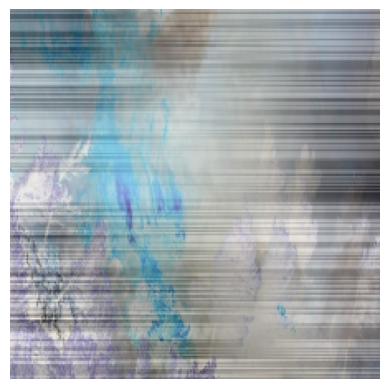

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from tf_explain.core.grad_cam import GradCAM

# Load the VGG16 model
model_VGG16 = load_model("model_VGG16 (2).h5")

# Function to compute Grad-CAM heatmap for a given image path and model
def compute_grad_cam(image_path, model):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(299, 299))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    # Create a GradCAM explainer
    explainer = GradCAM()

    # Compute Grad-CAM heatmap for the 'fire' class (assuming index 1)
    grid = explainer.explain((img_array, None), model, class_index=1)

    return grid[0]  # Select the heatmap for the first image in the batch

# Example usage for one image
image_path = "test/fire/test019.jpg"
heatmap_VGG16 = compute_grad_cam(image_path, model_VGG16)

# Load the original image
original_image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
original_image = tf.keras.preprocessing.image.img_to_array(original_image)

# Rescale the heatmap to match the original image size
heatmap_rescaled = cv2.resize(heatmap_VGG16, (224, 224))

# Normalize the heatmap to values between 0 and 1
heatmap_rescaled = heatmap_rescaled - np.min(heatmap_rescaled)
heatmap_rescaled = heatmap_rescaled / np.max(heatmap_rescaled)

# Convert the heatmap to a 3-channel format
heatmap_rescaled = np.expand_dims(heatmap_rescaled, axis=-1)
heatmap_rescaled = np.tile(heatmap_rescaled, [1, 1, 3])

# Overlay the heatmap on the original image
alpha = 0.5  # Set transparency of heatmap overlay
final_image = cv2.addWeighted(np.uint8(255 * original_image), alpha, np.uint8(255 * heatmap_rescaled), 1 - alpha, 0)

# Visualize the overlay
plt.imshow(final_image)
plt.axis('off')
plt.show()


test/fire/test005.jpg
1/1 [==============================] - 2s 2s/step
[1.0000000e+00 3.6510233e-08 4.7854543e-10]


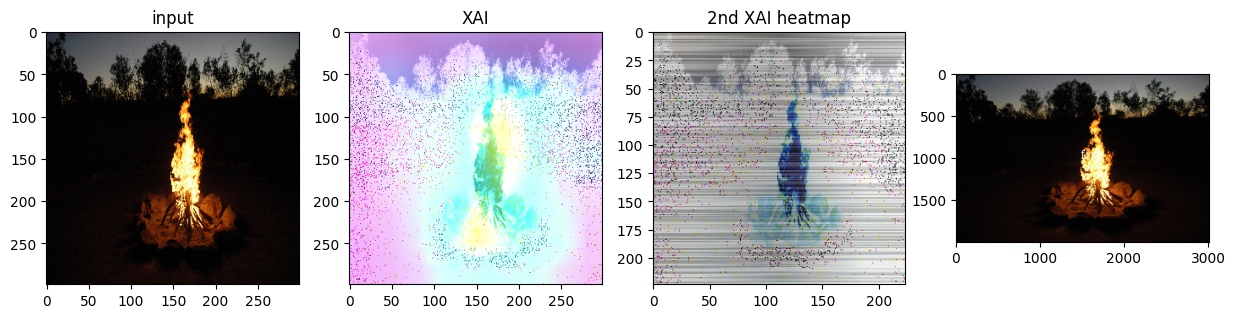

test/fire/test013.jpg
1/1 [==============================] - 2s 2s/step
[1.0000000e+00 3.1478786e-22 7.3853308e-24]


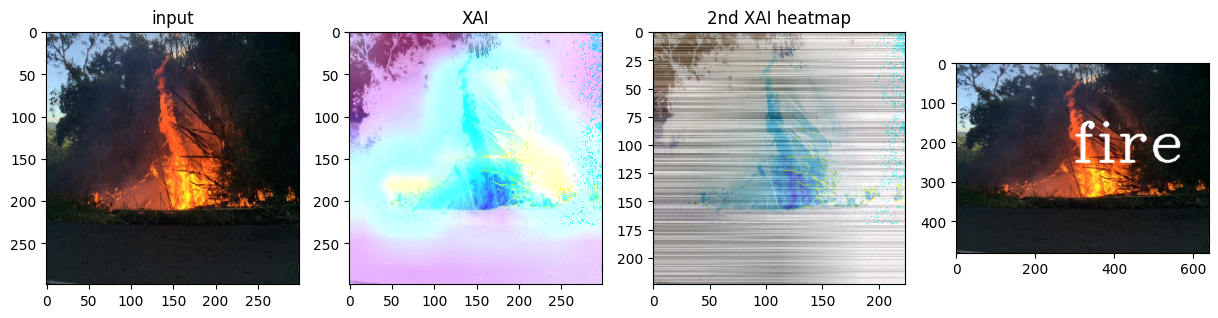

test/fire/test007.jpg
1/1 [==============================] - 2s 2s/step
[1.000000e+00 7.503966e-20 5.106619e-14]


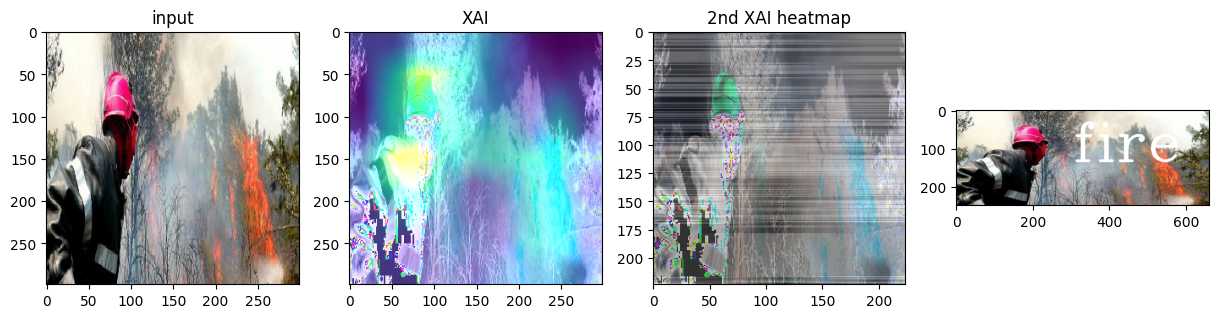

test/fire/F_2062.jpg
1/1 [==============================] - 1s 920ms/step
[1.0000000e+00 1.2142630e-23 1.8397202e-26]


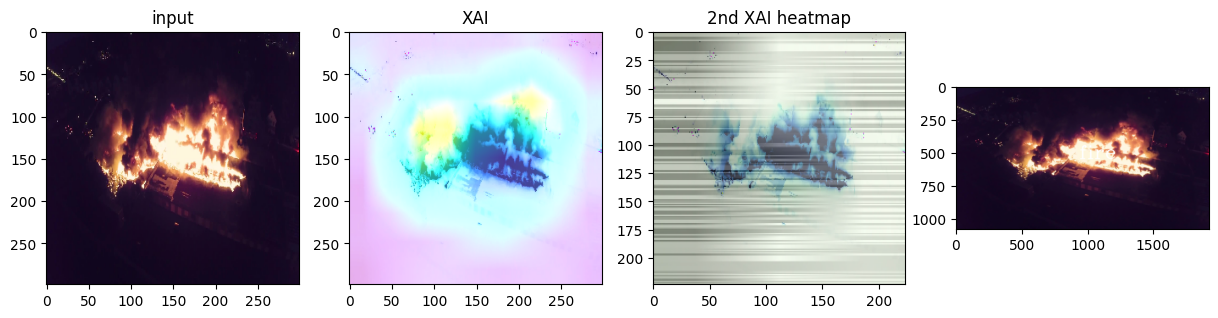

test/fire/F_2063.jpg
1/1 [==============================] - 1s 924ms/step
[1.0000000e+00 1.1565153e-17 3.1754210e-17]


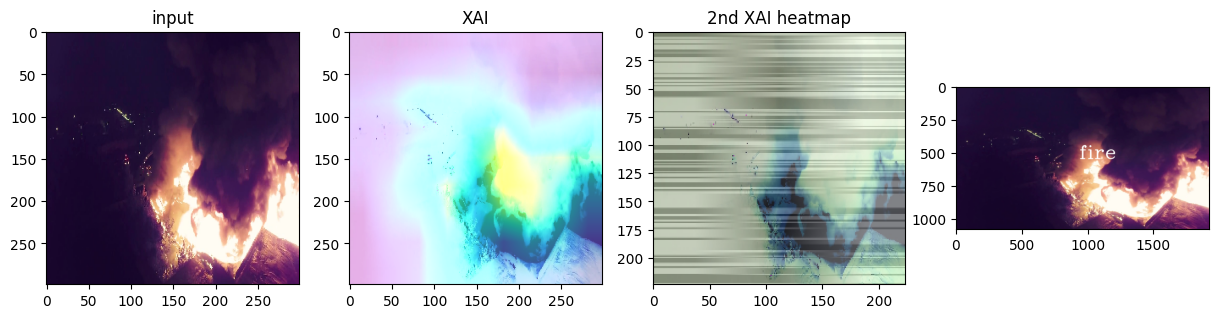

test/fire/F_2064.jpg
1/1 [==============================] - 1s 912ms/step
[1.0000000e+00 3.7149971e-15 1.4752287e-15]


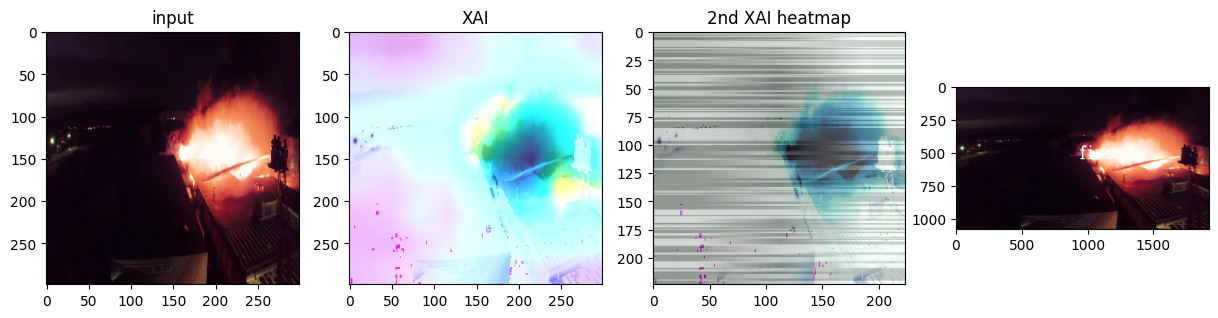

test/fire/F_2066.jpg
1/1 [==============================] - 1s 1s/step
[1.0000000e+00 3.1700772e-21 8.5845333e-25]


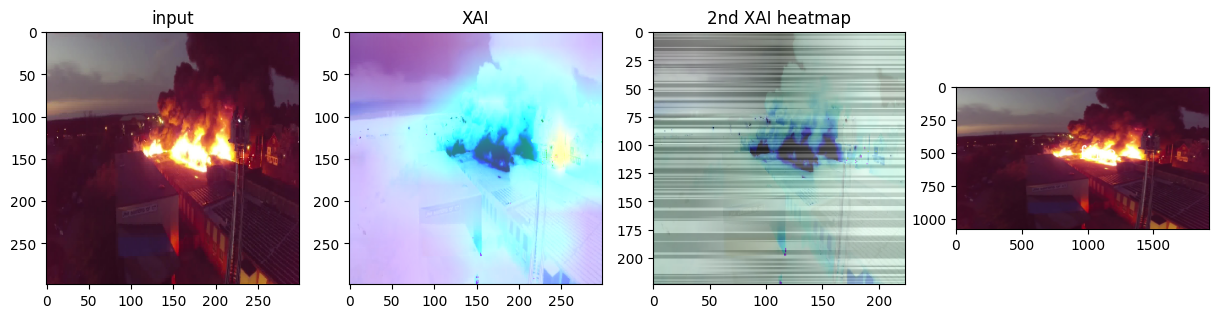

test/fire/F_2067.jpg
1/1 [==============================] - 1s 1s/step
[1.0000000e+00 1.8000148e-12 2.0140657e-11]


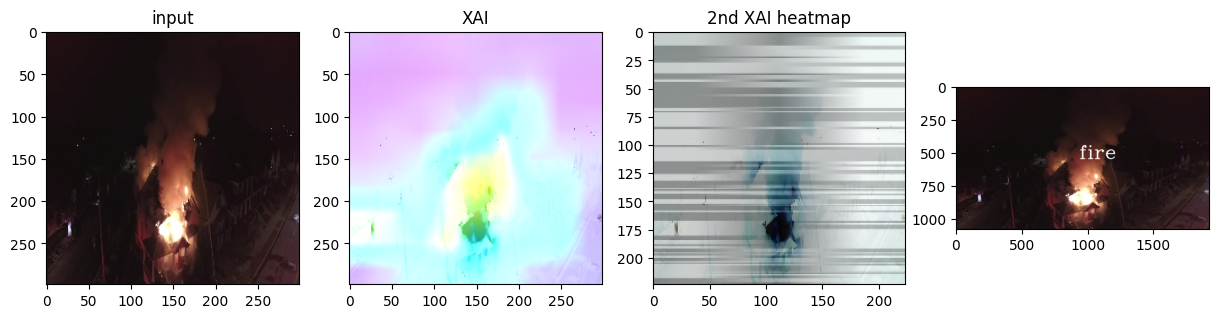

test/fire/F_2080.jpg
1/1 [==============================] - 1s 928ms/step
[1.0000000e+00 2.3298955e-11 3.8186130e-12]


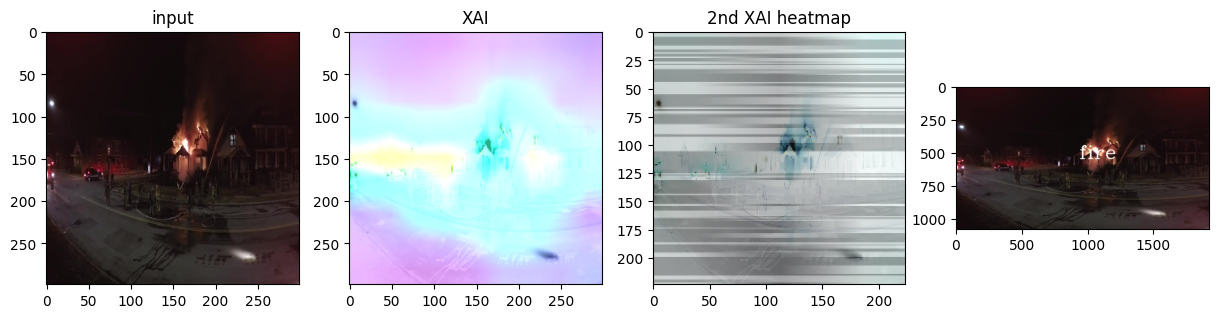

test/fire/F_2062.jpg
1/1 [==============================] - 1s 937ms/step
[1.0000000e+00 1.2142630e-23 1.8397202e-26]


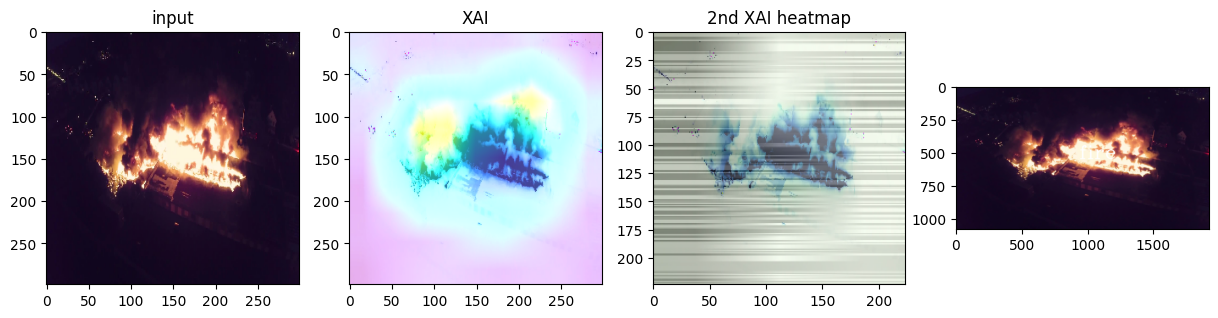

test/start_fire/test101.jpg
1/1 [==============================] - 1s 908ms/step
[1.07376845e-08 3.83666041e-08 1.00000000e+00]


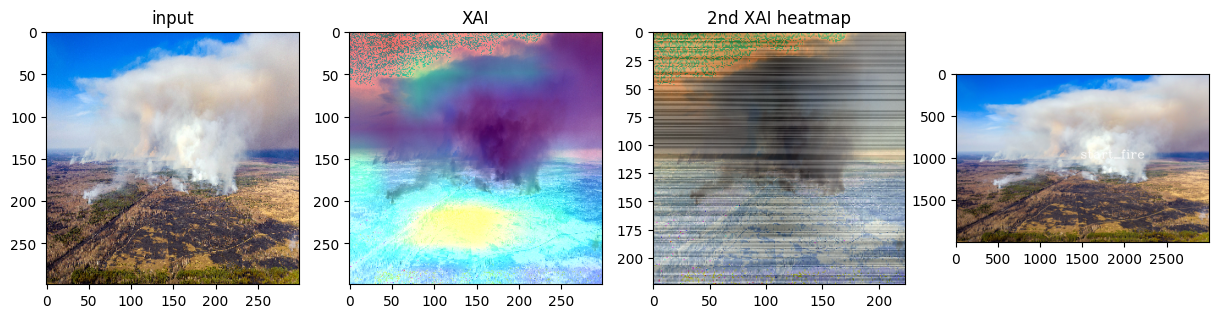

test/start_fire/test122.jpg
1/1 [==============================] - 1s 929ms/step
[2.8405659e-06 6.5567229e-10 9.9999714e-01]


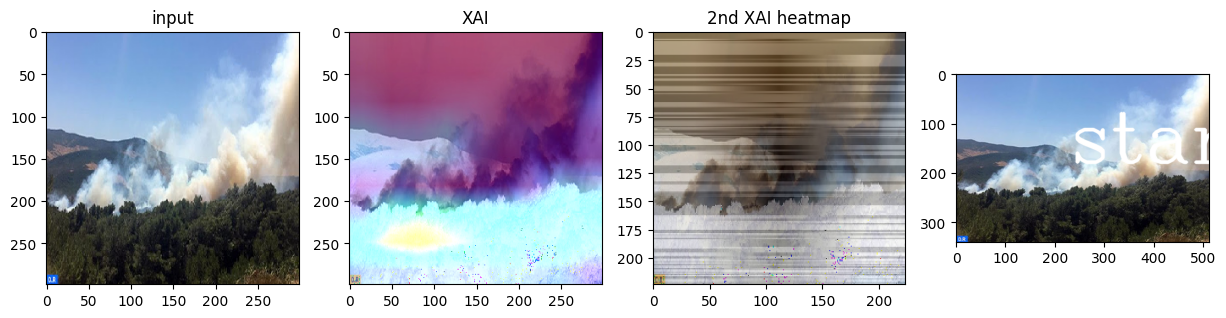

test/start_fire/NorthAmerica (79).png
1/1 [==============================] - 1s 1s/step
[2.2974840e-04 9.5737975e-12 9.9977022e-01]


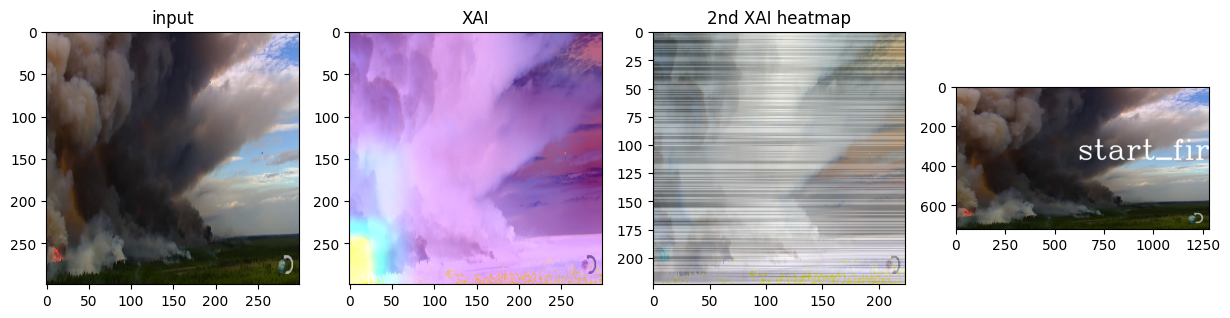

test/start_fire/test106.jpg
1/1 [==============================] - 1s 934ms/step
[1.4828278e-03 1.5619740e-05 9.9850154e-01]


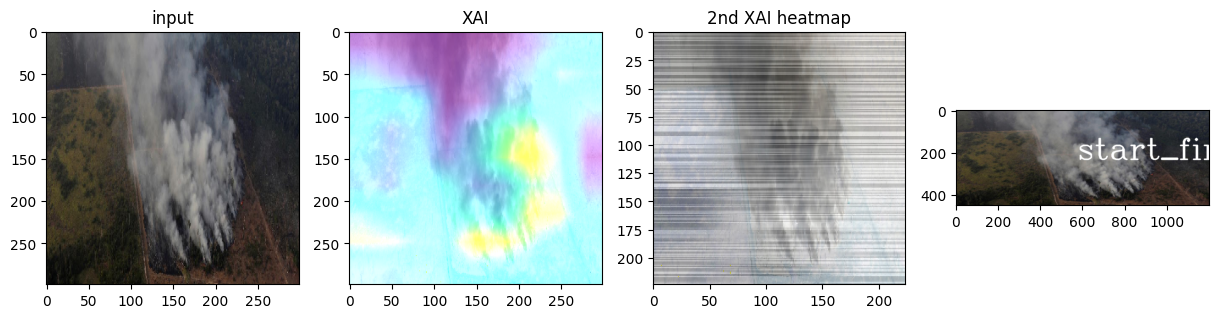

test/start_fire/test118.jpg
1/1 [==============================] - 1s 939ms/step
[5.00020431e-03 1.19922566e-04 9.94879842e-01]


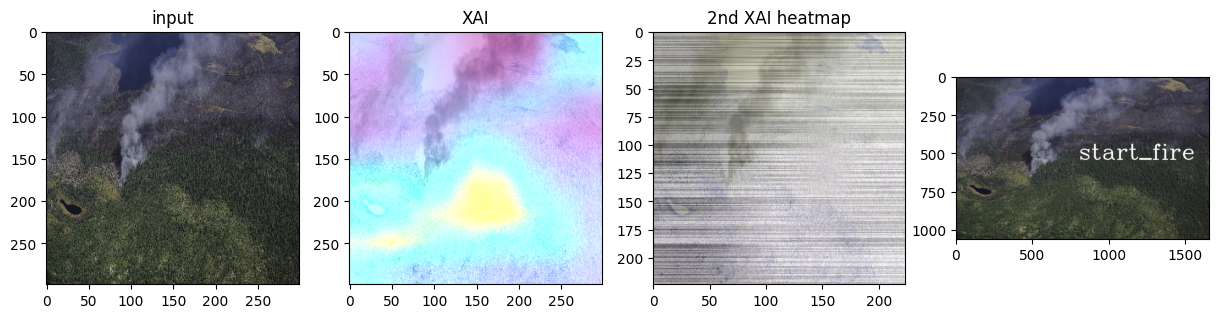

test/fire/test019.jpg
1/1 [==============================] - 1s 914ms/step
[1.0000000e+00 3.2327091e-23 5.3842406e-21]


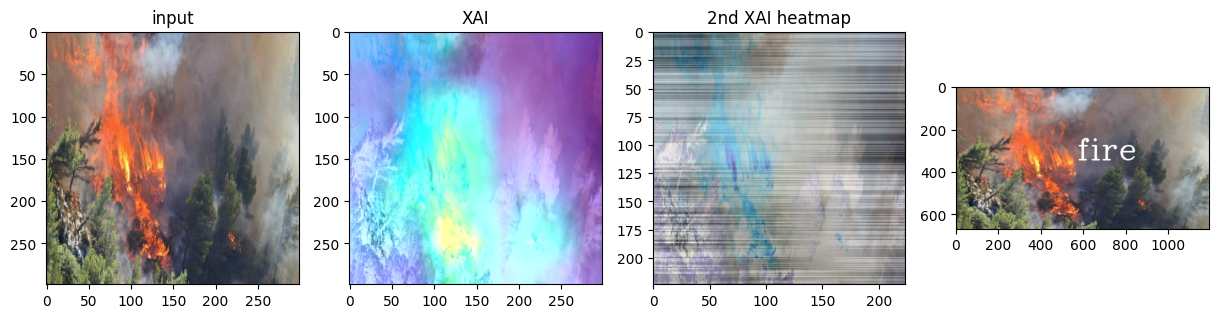

test/fire/test002.jpg
1/1 [==============================] - 2s 2s/step
[1.0000000e+00 4.6920873e-26 1.7348264e-22]


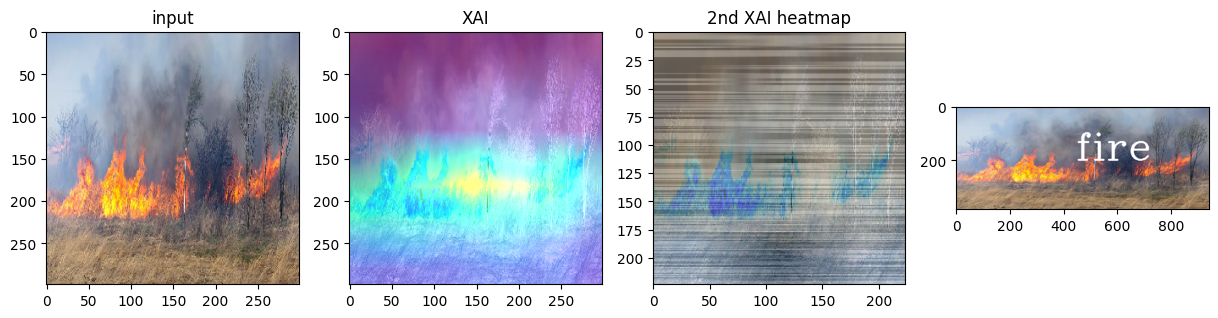

In [ ]:
for image_path in images_to_test:
    #imnum=[]
    print(image_path)
    # Load to the correct format and predict the current image
    img0 = tf.keras.preprocessing.image.load_img(image_path, target_size=(input_dim,input_dim))
    img = tf.keras.preprocessing.image.img_to_array(img0)

    data = ([img], None)
    xy=np.expand_dims(img,axis=0)
    myTuple=(xy,None)



    # Example usage for one image
    imag = image_path
    heatmap_VGG16 = compute_grad_cam(imag, model_VGG16)

    # Load the original image
    original_image = tf.keras.preprocessing.image.load_img(imag, target_size=(224, 224))
    original_image = tf.keras.preprocessing.image.img_to_array(original_image)

    # Rescale the heatmap to match the original image size
    heatmap_rescaled = cv2.resize(heatmap_VGG16, (224, 224))

    # Normalize the heatmap to values between 0 and 1
    heatmap_rescaled = heatmap_rescaled - np.min(heatmap_rescaled)
    heatmap_rescaled = heatmap_rescaled / np.max(heatmap_rescaled)

    # Convert the heatmap to a 3-channel format
    heatmap_rescaled = np.expand_dims(heatmap_rescaled, axis=-1)
    heatmap_rescaled = np.tile(heatmap_rescaled, [1, 1, 3])

    # Overlay the heatmap on the original image
    alpha = 0.5  # Set transparency of heatmap overlay
    final_image = cv2.addWeighted(np.uint8(255 * original_image), alpha, np.uint8(255 * heatmap_rescaled), 1 - alpha, 0)



    # Start explainer
    #explainer = SmoothGrad()
    explainer = GradCAM()
    grid = explainer.explain(myTuple, model_VGG16, class_index=1)
    temp = np.concatenate((img,grid),axis=1)
    fig, axs = plt.subplots(1, 4)
    axs[0].imshow(img.astype(np.uint8))
    axs[0].set_title("input")
    axs[1].imshow(grid.astype(np.uint8))
    axs[1].set_title("XAI")
    axs[2].imshow(final_image)
    axs[2].set_title("2nd XAI heatmap")

    fig.set_figheight(15)
    fig.set_figwidth(15)


    pred_VGG16 = model_VGG16.predict(xy,batch_size=1)[0]
    print(pred_VGG16)
    for (pos,prob) in enumerate(pred_VGG16):
      pos == np.argmax(pred_VGG16)
      img = cv2.imread(image_path)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      font = cv2.FONT_HERSHEY_COMPLEX
      textsize = cv2.getTextSize(className, font, 0.7, 2)[0]
      textX = (img.shape[1] - textsize[0]) / 2
      textY = (img.shape[0] + textsize[1]) / 2
      cv2.putText(img, classes[np.argmax(pred_VGG16)], (int(textX), int(textY)), font, 4.7, (255,255,255), 5, cv2.LINE_AA)
      axs[3].imshow(img)
    plt.show()



